# Content of the notebook

In this notebook we investigate the effect of the two additional features molecular weight and LogP-coefficient for the substrate for the Graph Neural Network. Therefore, we train and validate models with both, with only one, and with none of these features and compare the results. All models can either be trained or our pretrained weights can be loaded to validate the models. The notebook consists of the following steps:

1. Loading training and test data
2. Training a GNN with LogP and MW as additional input features
3. Training a GNN with MW as an additional input feature
4. Training a GNN with LogP as an additional input feature
5. Training a GNN without LogP and MW as additional input features
6. Comparing the performances and plotting figure 3 of our paper

All datasets are stored in one directory. The location of this directory can be changed (to the corresponding path on your PC) in the python file "directory_infomation.py".

Loading all the necessary packages and functions to execute the code:

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as plticker
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from directory_infomation import *
from functions_and_dicts_data_preprocessing_GNN import *
from build_GNN import *

plt.style.use('CCB_plot_style_0v4.mplstyle')
c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']        # define a high contrast color scheme

## 1. Loading training and test data

In [7]:
brenda_train = pd.read_pickle(join(datasets_dir, "splits", "training_data.pkl"))
brenda_train = brenda_train.loc[~pd.isnull(brenda_train["GNN FP"])]
brenda_test = pd.read_pickle(join(datasets_dir, "splits", "test_data.pkl"))
brenda_test = brenda_test.loc[~pd.isnull(brenda_test["GNN FP"])]

train_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
train_indices = [index[:index.rfind("_")] for index in train_indices]
train_indices = list(set([index for index in train_indices if "train" in index]))


test_indices = os.listdir(join(datasets_dir, "GNN_input_data"))
test_indices = [index[:index.rfind("_")] for index in test_indices]
test_indices = list(set([index for index in test_indices if "test" in index]))

with open(join(datasets_dir, "splits", "CV_indices_test"), 'rb') as fp:
    CV_indices_test = pickle.load(fp)
    
with open(join(datasets_dir, "splits", "CV_indices_train"), 'rb') as fp:
    CV_indices_train = pickle.load(fp)

In [3]:
batch_size = 64
D = 50
learning_rate = 0.05
epochs = 50
l2_reg_fc = 1
l2_reg_conv = 0.01
rho = 0.95

## 2. Training a GNN with LogP and MW as additional input features

### (a) Training the GNN:

In [4]:
'''train_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : train_indices,
              'shuffle': True}

test_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : test_indices,
              'shuffle': False}

training_generator = DataGenerator(**train_params)
test_generator = DataGenerator(**test_params)

model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)

model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 0)
model.save_weights(join(datasets_dir, "model_weights", "saved_model_GNN_best_hyperparameters_V2"))
''';

Loading the already trained model:

In [5]:
train_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : train_indices,
              'shuffle': True}

test_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : test_indices,
              'shuffle': False}

training_generator = DataGenerator(**train_params)
test_generator = DataGenerator(**test_params)

model = DMPNN(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)

model.load_weights(join(datasets_dir, "model_weights", "saved_model_GNN_best_hyperparameters"))

### (b) Fitting gradient boosting model model:

Extract fingerprints for Gradient Boosting model:

In [6]:
get_fingerprint_fct = K.function([model.layers[0].input, model.layers[26].input,
                                  model.layers[3].input, model.layers[36].input],
                                  [model.layers[-10].output])


brenda_train_with_rep = get_substrate_representations(df = brenda_train, training_set = True, 
                                                      get_fingerprint_fct = get_fingerprint_fct)
brenda_test_with_rep = get_substrate_representations(df = brenda_test, training_set = False, 
                                                     get_fingerprint_fct = get_fingerprint_fct)

brenda_train = brenda_train_with_rep.loc[~pd.isnull(brenda_train_with_rep["GNN FP"])]
brenda_test = brenda_test_with_rep.loc[~pd.isnull(brenda_test_with_rep["GNN FP"])]



train_GNN = np.array(list(brenda_train["GNN FP"]))
test_GNN = np.array(list(brenda_test["GNN FP"]))
train_Y = np.array(list(brenda_train["log10_KM"]))
test_Y = np.array(list(brenda_test["log10_KM"]))

145
36


#### (i) 5-fold Cross Validation:

In [7]:
best_gnn_param = best_gnn_param = {'learning_rate': 0.11663442585733919,
                 'max_delta_step': 4.103293476480144,
                 'max_depth': 4.953377961760086,
                 'min_child_weight': 9.731324861736825,
                 'num_rounds': 82.28862882817994,
                 'reg_alpha': 0.49379272012357756,
                 'reg_lambda': 4.683671598466882}

param = best_gnn_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_GNN[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_GNN[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    


np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_CV_MSE.npy"), MSE)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_CV_R2.npy"), R2)

#### (ii) Training the model on the whole training set and validating it on the test set:

In [8]:
dtrain = xgb.DMatrix(train_GNN, label = train_Y)
dtest = xgb.DMatrix(test_GNN)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_substrate_only.dat"), "wb"))
y_test_pred = bst.predict(dtest)
MSE_GNN_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_GNN_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_GNN = abs(np.reshape(test_Y, (-1)) - y_test_pred)


np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_test_MSE.npy"), MSE_GNN_test)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_test_R2.npy"), R2_GNN_test)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_pred_test.npy"), y_test_pred)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_pred_abs_errors.npy"),
        abs(y_test_pred - test_Y))

## 3. Training a GNN with MW as an additional input feature

### (a) Training the GNN:

In [9]:
train_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : train_indices,
              'shuffle': True}

test_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : test_indices,
              'shuffle': False}

training_generator = DataGenerator(**train_params)
test_generator = DataGenerator(**test_params)

model = DMPNN_with_MW(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)

model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 0)


  ...
    to  
  ['...']


### (b) Fitting gradient boosting model model:

Extract fingerprints for Gradient Boosting model:

In [10]:
get_fingerprint_fct = K.function([model.layers[0].input, model.layers[26].input,
                                  model.layers[3].input, model.layers[35].input],
                                  [model.layers[-10].output])


brenda_train_with_rep = get_substrate_representations(df = brenda_train, training_set = True, 
                                                      get_fingerprint_fct = get_fingerprint_fct)
brenda_test_with_rep = get_substrate_representations(df = brenda_test, training_set = False, 
                                                     get_fingerprint_fct = get_fingerprint_fct)

brenda_train = brenda_train_with_rep.loc[~pd.isnull(brenda_train_with_rep["GNN FP"])]
brenda_test = brenda_test_with_rep.loc[~pd.isnull(brenda_test_with_rep["GNN FP"])]


train_GNN = np.array(list(brenda_train["GNN FP"]))
test_GNN = np.array(list(brenda_test["GNN FP"]))
train_Y = np.array(list(brenda_train["log10_KM"]))
test_Y = np.array(list(brenda_test["log10_KM"]))

145
36


#### (i) 5-fold Cross Validation:

In [11]:
best_gnn_param = best_gnn_param = {'learning_rate': 0.11663442585733919,
                 'max_delta_step': 4.103293476480144,
                 'max_depth': 4.953377961760086,
                 'min_child_weight': 9.731324861736825,
                 'num_rounds': 82.28862882817994,
                 'reg_alpha': 0.49379272012357756,
                 'reg_lambda': 4.683671598466882}

param = best_gnn_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_GNN[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_GNN[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    

np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_MW_CV_MSE.npy"), MSE)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_MW_CV_R2.npy"), R2)

#### (ii) Training the model on the whole training set and validating it on the test set:

In [12]:
dtrain = xgb.DMatrix(train_GNN, label = train_Y)
dtest = xgb.DMatrix(test_GNN)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_substrate_only.dat"), "wb"))
y_test_pred = bst.predict(dtest)
MSE_GNN_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_GNN_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_GNN = abs(np.reshape(test_Y, (-1)) - y_test_pred)


np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_MW_test_MSE.npy"), MSE_GNN_test)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_MW_test_R2.npy"), R2_GNN_test)

## 4. Training a GNN with LogP as an additional input feature

### (a) Training the GNN:

In [13]:
train_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : train_indices,
              'shuffle': True}

test_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : test_indices,
              'shuffle': False}

training_generator = DataGenerator(**train_params)
test_generator = DataGenerator(**test_params)

model = DMPNN_with_LogP(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)

model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 0)

  ...
    to  
  ['...']


### (b) Fitting gradient boosting model model:

Extract fingerprints for Gradient Boosting model:

In [14]:
get_fingerprint_fct = K.function([model.layers[0].input, model.layers[26].input,
                                  model.layers[3].input, model.layers[35].input],
                                  [model.layers[-10].output])


brenda_train_with_rep = get_substrate_representations(df = brenda_train, training_set = True, 
                                                      get_fingerprint_fct = get_fingerprint_fct)
brenda_test_with_rep = get_substrate_representations(df = brenda_test, training_set = False, 
                                                     get_fingerprint_fct = get_fingerprint_fct)

brenda_train = brenda_train_with_rep.loc[~pd.isnull(brenda_train_with_rep["GNN FP"])]
brenda_test = brenda_test_with_rep.loc[~pd.isnull(brenda_test_with_rep["GNN FP"])]


train_GNN = np.array(list(brenda_train["GNN FP"]))
test_GNN = np.array(list(brenda_test["GNN FP"]))
train_Y = np.array(list(brenda_train["log10_KM"]))
test_Y = np.array(list(brenda_test["log10_KM"]))

145
36


#### (i) 5-fold Cross Validation:

In [15]:
best_gnn_param = best_gnn_param = {'learning_rate': 0.11663442585733919,
                 'max_delta_step': 4.103293476480144,
                 'max_depth': 4.953377961760086,
                 'min_child_weight': 9.731324861736825,
                 'num_rounds': 82.28862882817994,
                 'reg_alpha': 0.49379272012357756,
                 'reg_lambda': 4.683671598466882}

param = best_gnn_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_GNN[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_GNN[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    

np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_CV_MSE.npy"), MSE)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_CV_R2.npy"), R2)

#### (ii) Training the model on the whole training set and validating it on the test set:

In [16]:
dtrain = xgb.DMatrix(train_GNN, label = train_Y)
dtest = xgb.DMatrix(test_GNN)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_substrate_only.dat"), "wb"))
y_test_pred = bst.predict(dtest)
MSE_GNN_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_GNN_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_GNN = abs(np.reshape(test_Y, (-1)) - y_test_pred)


np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_test_MSE.npy"), MSE_GNN_test)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_test_R2.npy"), R2_GNN_test)

## 5. Training a GNN without LogP and MW as additional input features

### (a) Training the GNN:

In [17]:
train_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : train_indices,
              'shuffle': True}

test_params = {'batch_size': batch_size,
              'folder' :join(datasets_dir, "GNN_input_data"),
              'list_IDs' : test_indices,
              'shuffle': False}

training_generator = DataGenerator(**train_params)
test_generator = DataGenerator(**test_params)

model = DMPNN_without_extra_features(l2_reg_conv = l2_reg_conv, l2_reg_fc = l2_reg_fc, learning_rate = learning_rate,
                  D = D, N = N, F1 = F1, F2 = F2, F= F, drop_rate = 0.0, ada_rho = rho)

model.fit(training_generator, epochs= epochs, shuffle = True, verbose = 0)

  ...
    to  
  ['...']


### (b) Fitting gradient boosting model model:

Extract fingerprints for Gradient Boosting model:

In [18]:
input_data_folder = join(datasets_dir, "GNN_input_data") 
def get_substrate_representations(df, training_set, get_fingerprint_fct):
    df["GNN FP"] = ""
    i = 0
    n = len(df)
    
    cid_all = list(df.index)
    if training_set == True:
        prefix = "train_"
    else:
        prefix = "test_"
    cid_all = [prefix + str(cid) for cid in cid_all]
    
    while i*64 <= n:
        if (i+1)*64  <= n:
            XE, X, A, extras = get_representation_input(cid_all[i*64:(i+1)*64])
            representations = get_fingerprint_fct([np.array(XE), np.array(X),np.array(A)])[0]
            df["GNN FP"][i*64:(i+1)*64] = list(representations[:, :52])
        else:
            print(i)
            XE, X, A, extras = get_representation_input(cid_all[-64:])
            representations = get_fingerprint_fct([np.array(XE), np.array(X),np.array(A)])[0]
            df["GNN FP"][-64:] = list(representations[:, :52])
        i += 1
        
    ### set all GNN FP-entries with no input matrices to np.nan:
    all_X_matrices = os.listdir(input_data_folder)
    for ind in df.index:
        if prefix +str(ind) +"_X.npy" not in all_X_matrices:
            df["GNN FP"][ind] = np.nan
    return(df)

In [19]:
get_fingerprint_fct = K.function([model.layers[0].input, model.layers[26].input,
                                  model.layers[3].input],
                                  [model.layers[-10].output])


brenda_train_with_rep = get_substrate_representations(df = brenda_train, training_set = True, 
                                                      get_fingerprint_fct = get_fingerprint_fct)
brenda_test_with_rep = get_substrate_representations(df = brenda_test, training_set = False, 
                                                     get_fingerprint_fct = get_fingerprint_fct)

brenda_train = brenda_train_with_rep.loc[~pd.isnull(brenda_train_with_rep["GNN FP"])]
brenda_test = brenda_test_with_rep.loc[~pd.isnull(brenda_test_with_rep["GNN FP"])]


train_GNN = np.array(list(brenda_train["GNN FP"]))
test_GNN = np.array(list(brenda_test["GNN FP"]))
train_Y = np.array(list(brenda_train["log10_KM"]))
test_Y = np.array(list(brenda_test["log10_KM"]))

145
36


#### (i) 5-fold Cross Validation:

In [20]:
best_gnn_param = best_gnn_param = {'learning_rate': 0.11663442585733919,
                 'max_delta_step': 4.103293476480144,
                 'max_depth': 4.953377961760086,
                 'min_child_weight': 9.731324861736825,
                 'num_rounds': 82.28862882817994,
                 'reg_alpha': 0.49379272012357756,
                 'reg_lambda': 4.683671598466882}

param = best_gnn_param
num_round = param["num_rounds"]
del param["num_rounds"]

param["max_depth"] = int(np.round(param["max_depth"]))

R2 = []
MSE = []

for i in range(5):
    train_index, test_index  = CV_indices_train[i], CV_indices_test[i]
    train_index = [True if ind in train_index else False for ind in list(brenda_train.index)]
    test_index = [True if ind in test_index else False for ind in list(brenda_train.index)]
    
    dtrain = xgb.DMatrix(train_GNN[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_GNN[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))

np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_CV_MSE.npy"), MSE)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_CV_R2.npy"), R2)

#### (ii) Training the model on the whole training set and validating it on the test set:

In [21]:
dtrain = xgb.DMatrix(train_GNN, label = train_Y)
dtest = xgb.DMatrix(test_GNN)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
pickle.dump(bst, open(join(datasets_dir, "model_weights", "xgboost_model_substrate_only.dat"), "wb"))
y_test_pred = bst.predict(dtest)
MSE_GNN_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
R2_GNN_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
absolute_errors_GNN = abs(np.reshape(test_Y, (-1)) - y_test_pred)

np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_test_MSE.npy"), MSE_GNN_test)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_test_R2.npy"), R2_GNN_test)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_pred_test.npy"), y_test_pred)
np.save(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_pred_abs_errors.npy"),
        abs(y_test_pred - test_Y))

## 6. Comparing the performances and plotting figure 3 of the paper

Loading training and test results:

In [8]:
CV_MSE_LogP_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_CV_MSE.npy"))
CV_MSE_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_MW_CV_MSE.npy"))
CV_MSE_LogP = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_CV_MSE.npy"))
CV_MSE = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_CV_MSE.npy"))

CV_R2_LogP_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_CV_R2.npy"))
CV_R2_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_MW_CV_R2.npy"))
CV_R2_LogP = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_CV_R2.npy"))
CV_R2 = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_CV_R2.npy"))

test_MSE_LogP_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_test_MSE.npy"))
test_MSE_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_MW_test_MSE.npy"))
test_MSE_LogP = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_test_MSE.npy"))
test_MSE = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_test_MSE.npy"))

test_R2_LogP_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_with_LogP_and_MW_test_R2.npy"))
test_R2_MW = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW","GB_with_MW_test_R2.npy"))
test_R2_LogP = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW","GB_with_LogP_test_R2.npy"))
test_R2 = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW", "GB_without_extra_features_test_R2.npy"))


#### Figure 3a:

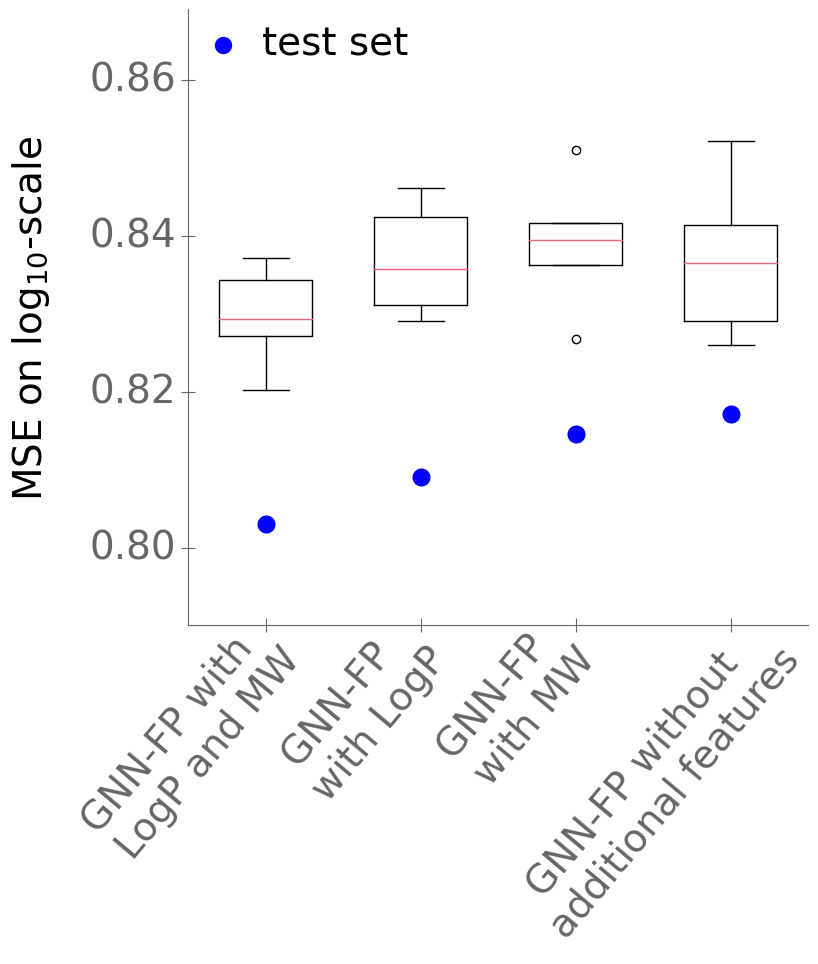

In [19]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

plt.scatter(1, test_MSE_LogP_MW , c='blue', marker='o', linewidths= 8, label = "test set")
plt.scatter(2, test_MSE_LogP, c='blue', marker='o', linewidths= 8)
plt.scatter(3, test_MSE_MW, c='blue', marker='o', linewidths= 8)
plt.scatter(4, test_MSE, c='blue', marker='o', linewidths= 8)


plt.boxplot([CV_MSE_LogP_MW,  CV_MSE_LogP, CV_MSE_MW, CV_MSE], positions=[1,2,3,4],  widths=0.6)

plt.ylim(0.79, 0.869)

ax.locator_params(axis="y", nbins=4)

ticks1 = [1,2,3,4]
ax.set_xticks(ticks1)
ax.set_xticklabels([])
ax.tick_params(axis='x', which="major", length=10)
ax.tick_params(axis='y', length=10)
#ax.locator_params(axis="y", nbins=4)


ticks2 = [0.5, 1.6, 2.6, 3.5]
labs = ["GNN-FP with \n LogP and MW", "GNN-FP \n with LogP", "GNN-FP \n with MW", "GNN-FP without \n additional features"]
ax.set_xticks(ticks2, minor=True)
ax.set_xticklabels(labs, minor=True, y= 0.03)
ax.tick_params(axis='x', which="minor",length=0, rotation = 50)
loc = plticker.MultipleLocator(base=0.02) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

plt.ylabel("MSE on $\log_{10}$-scale")
ax.yaxis.set_label_coords(-0.22, 0.5)
plt.legend(loc = "upper left")
plt.show()

#### Figure 3b:

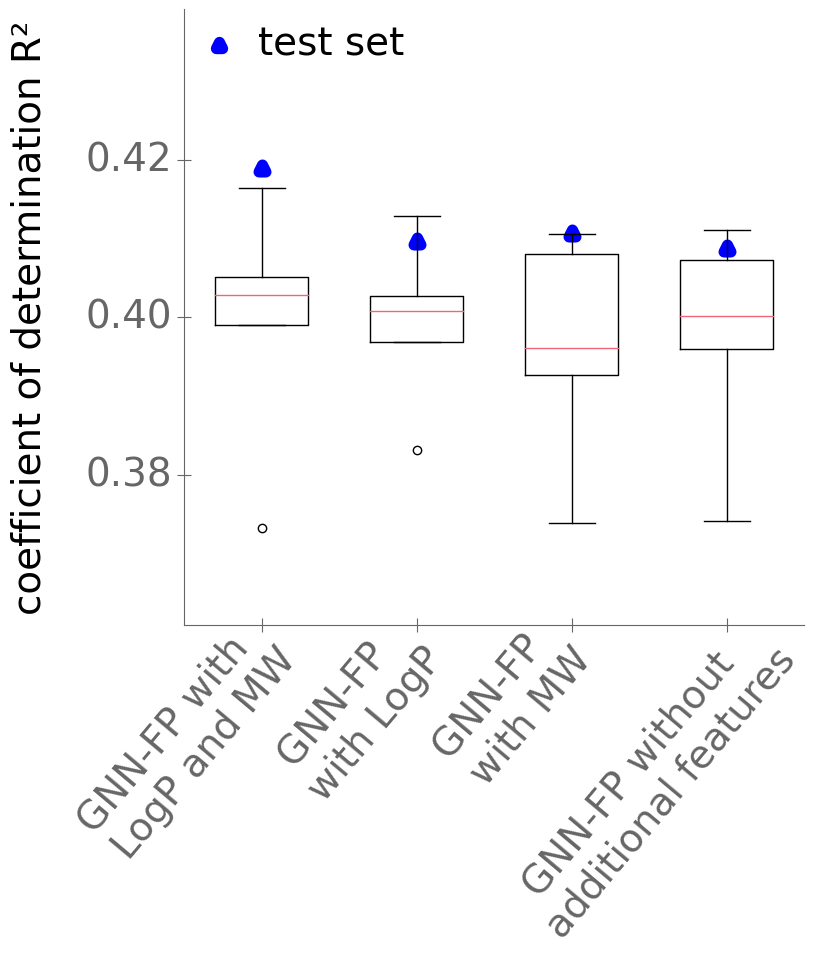

In [21]:
fig, ax = plt.subplots(figsize= (8,8))
plt.rcParams.update({'font.size': 28})

plt.scatter(1, test_R2_LogP_MW , c='blue', marker='^', linewidths= 8, label = "test set")
plt.scatter(2, test_R2_LogP, c='blue', marker='^', linewidths= 8)
plt.scatter(3, test_R2_MW, c='blue', marker='^', linewidths= 8)
plt.scatter(4, test_R2, c='blue', marker='^', linewidths= 8)


plt.boxplot([CV_R2_LogP_MW,  CV_R2_LogP, CV_R2_MW, CV_R2], positions=[1,2,3,4],  widths=0.6, whis =2)

plt.ylim(0.361, 0.439)

ticks1 = [1,2,3,4]
ax.set_xticks(ticks1)
ax.set_xticklabels([])



ax.tick_params(axis='x', which="major", length=10)
ax.tick_params(axis='y', length=10)

ticks2 = [0.5, 1.6, 2.6, 3.5]
labs = ["GNN-FP with \n LogP and MW", "GNN-FP \n with LogP", "GNN-FP \n with MW", "GNN-FP without \n additional features"]
ax.set_xticks(ticks2, minor=True)
ax.set_xticklabels(labs, minor=True, y= 0.03)
ax.tick_params(axis='x', which="minor",length=0, rotation = 50)
loc = plticker.MultipleLocator(base=0.02) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

plt.ylabel("coefficient of determination R²")
ax.yaxis.set_label_coords(-0.22, 0.5)
plt.legend(loc = "upper left")
plt.show()

In [25]:
abs_errors = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW",
                          "GB_without_extra_features_pred_abs_errors.npy"))
abs_errors_full = np.load(join(datasets_dir, "training_results", "effect_of_LogP_and_MW",
                               "GB_with_LogP_and_MW_pred_abs_errors.npy"))

from scipy.stats import wilcoxon

d = abs_errors_full- abs_errors
w, p = wilcoxon(d, alternative='less')
print(w,p)

1330707.0 0.12479701343862631
